#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import random
from scipy import ndimage
import time
import sys
from tqdm import tqdm
import math
from PIL import Image
from keras.models import load_model

#Mount Drive

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

In [ ]:
os.chdir('/content/drive/MyDrive/EAI')

#Download Dataset

In [ ]:
!wget  'http://giagu.web.cern.ch/giagu/CERN/mri_motion_data_v1.tgz'

In [ ]:
!tar -xvzf  '/content/mri_motion_data_v1.tgz' -C './'


#Dataset Images

In [ ]:
!ls
img = nib.load( './dataset/train/img/img_1.nii.gz')
img_corr = nib.load('./dataset/train/img_corr/img_motion_1.nii.gz')

img = img.get_fdata()
img_corr = img_corr.get_fdata()

In [ ]:
slice_x = img.shape[0]//2
slice_y = img.shape[1]//2
slice_z = img.shape[2]//2

def flip(x):
  return np.rot90(x)

plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
plt.imshow(flip(img[slice_x,:,:]), cmap = 'gray', interpolation = 'none')
plt.subplot(2,3,2)
plt.imshow(flip(img[:, slice_y,:]), cmap = 'gray', interpolation = 'none')
plt.subplot(2,3,3)
plt.imshow(flip(img[:,:,slice_z]), cmap = 'gray', interpolation = 'none')

plt.figure(figsize=(15,15))
plt.subplot(2,3,4)
plt.imshow(flip(img_corr[slice_x,:,:]), cmap = 'gray', interpolation = 'none')
plt.subplot(2,3,5)
plt.imshow(flip(img_corr[:, slice_y,:]), cmap = 'gray', interpolation = 'none')
plt.subplot(2,3,6)
plt.imshow(flip(img_corr[:,:,slice_z]), cmap = 'gray', interpolation = 'none')

print(img_corr[slice_x,:,:].shape)

#Image Preprocessing

##Image Functions

In [ ]:
def flip(x):
  return np.rot90(x)

In [ ]:
def show_scans(img):
  slice_x = img.shape[0]//2
  slice_y = img.shape[1]//2
  slice_z = img.shape[2]//2

  plt.figure(figsize=(15,15))
  plt.subplot(2,3,1)
  plt.imshow(flip(img[slice_x,:,:]), cmap = 'gray', interpolation = 'none')
  plt.subplot(2,3,2)
  plt.imshow(flip(img[:, slice_y,:]), cmap = 'gray', interpolation = 'none')
  plt.subplot(2,3,3)
  plt.imshow(flip(img[:,:,slice_z]), cmap = 'gray', interpolation = 'none')

In [ ]:
def scan_to_img(img,i, prefix):
  slice_x = img.shape[0]//2
  slice_y = img.shape[1]//2
  slice_z = img.shape[2]//2

  flipped_x= flip(img[slice_x,:,:])
  flipped_y= flip(img[:, slice_y,:])
  flipped_z= flip(img[:,:,slice_z])

  #plt.imsave("./dataset/all_images/"+prefix+"x_"+str(i)+".png", flipped_x)
  #plt.imsave("./dataset/all_images/"+prefix+"y_"+str(i)+".png", flipped_y)
  #plt.imsave("./dataset/all_images/"+prefix+"z_"+str(i)+".png", flipped_z)

  nib.save(nib.Nifti1Image(flipped_x,affine=np.eye(4)), "./dataset/nibabel_images/"+prefix+"x_"+str(i)+".nii" )
  nib.save(nib.Nifti1Image(flipped_y,affine=np.eye(4)), "./dataset/nibabel_images/"+prefix+"y_"+str(i)+".nii" )
  nib.save(nib.Nifti1Image(flipped_z,affine=np.eye(4)), "./dataset/nibabel_images/"+prefix+"z_"+str(i)+".nii" )
  return [flipped_x,flipped_y ,flipped_z]

##Define Path

In [ ]:
#img= original images
original_scan_paths = [
    os.path.join("./dataset/train/img", x)
    for x in os.listdir("./dataset/train/img")
]
#img_corr= corrupted images
corrupted_scan_paths = [
    os.path.join("./dataset/train/img_corr", x)
    for x in os.listdir("./dataset/train/img_corr")
]

print("original images: " + str(len(original_scan_paths)))
print("corrupted images: " + str(len(corrupted_scan_paths)))

In [ ]:
#drive virgi

#img= original images
original_scan_paths = [
    os.path.join("./img", x)
    for x in os.listdir("./img")
]
#img_corr= corrupted images
corrupted_scan_paths = [
    os.path.join("./img_corr", x)
    for x in os.listdir("./img_corr")
]

print("original images: " + str(len(original_scan_paths)))
print("corrupted images: " + str(len(corrupted_scan_paths)))

##Nifti Preprocessing

In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    #print(filepath)
    #show_scans(scan)
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -255
    max = 255
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("uint8")
    return volume


def resize_volume(img):
    """Resize across z-axis"""

    # Get current depth
    current_depth = img.shape[-1]
    desired_depth = 256
    desired_width = 256
    desired_height = 256
    #print(img.shape)

    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1/ depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, (0,1), reshape=True)
    # Resize across z-axis
    #print(current_depth, desired_depth, depth_factor)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    #volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

## nii to images

In [ ]:
#outputs scans

# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
corrupted_scans = np.array([process_scan(path) for path in corrupted_scan_paths])
#print(corrupted_scan_paths)
print(corrupted_scans.shape)
for i in range(corrupted_scans.shape[0]):
  show_scans(corrupted_scans[i])
original_scans = np.array([process_scan(path) for path in original_scan_paths])

# For the corrupted MRI scans
# assign 1, for the original ones assign 0.
corrupted_labels = np.array([1 for _ in range(len(corrupted_scans))])
original_labels = np.array([0 for _ in range(len(original_scans))])

# Join corrupted and original in x and y
x_train = np.concatenate((corrupted_scans, original_scans), axis=0)

y_train = np.concatenate((corrupted_labels, original_labels), axis=0)
print(
    "Number of samples in train is %d."
    % (x_train.shape[0])
)

In [ ]:
#single path input
def collect_scans(paths):
  collected_scans= []
  i = 0;
  for path in paths:
    img = process_scan(path)
    collected_scans.append(scan_to_img(img))
    #print(path)


  collected_scans= np.array(collected_scans)
  #print(collected_scans.shape)
  #for x in collected_scans:
  #  for img in x:
  #    plt.figure(figsize=(15,15))
  #    plt.subplot(2,3,1)
  #    plt.imshow(img, cmap = 'gray', interpolation = 'none')
  return collected_scans


In [ ]:

def collect_scans_two(corr_paths, orig_paths):
  collected_scans= []
  #for idx, (path) in enumerate(corr_paths):
  #  print(path)
  #  img = process_scan(path)
  #  collected_scans.append(scan_to_img(img,idx,"img_corr_"))
  #  #print(path)
  for idx, (path) in enumerate(orig_paths[13:], 13):
    print(path)
    img = process_scan(path)
    collected_scans.append(scan_to_img(img,idx, "img_"))
    #print(path)

  collected_scans= np.array(collected_scans)
  #print(collected_scans.shape)
  #for x in collected_scans:
  #  for img in x:
  #    plt.figure(figsize=(15,15))
  #    plt.subplot(2,3,1)
  #    plt.imshow(img, cmap = 'gray', interpolation = 'none')
  return collected_scans
collect_scans_two(corrupted_scan_paths,original_scan_paths)

In [ ]:
total_scans = []
for i in range(575):
  slice_x_corr = tf.keras.utils.img_to_array(
      Image.open(
          './dataset/all_images/img_corr_x_'+str(i)+'.png'
          ).convert('RGB').convert('L').resize((64,64)))
  print(slice_x_corr.dtype)
  slice_y_corr = np.asarray(
      Image.open(
          './dataset/all_images/img_corr_y_'+str(i)+'.png'
          ).convert('RGB').convert('L'))
  slice_z_corr = np.asarray(
      Image.open(
          './dataset/all_images/img_corr_z_'+str(i)+'.png'
          ).convert('RGB').convert('L'))
  total_scans.append([slice_x_corr])#,slice_y_corr,slice_z_corr])
for i in range(575):
  slice_x_orig = tf.keras.utils.img_to_array(
      Image.open(
          './dataset/all_images/img_x_'+str(i)+'.png'
          ).convert('RGB').convert('L').resize((64,64)))
  slice_y_orig = np.asarray(
      Image.open(
          './dataset/all_images/img_y_'+str(i)+'.png'
          ).convert('RGB').convert('L'))
  slice_z_orig = np.asarray(
      Image.open(
          './dataset/all_images/img_z_'+str(i)+'.png'
          ).convert('RGB').convert('L'))
  total_scans.append([slice_x_orig])#,slice_y_orig,slice_z_orig])
total_scans = np.array(total_scans)
print(total_scans.shape)


In [ ]:
#total_scans = np.array(collect_scans_two(corrupted_scan_paths,original_scan_paths))
total_scans = []
for img in list(os.walk('./dataset/all_images/img_corr'))[0][2]:
  try:
    get_img = np.asarray(Image.open('./dataset/all_images/img_corr/'+img).convert('RGB').convert('L'))
    total_scans.append(get_img)
    plt.imshow(get_img)
  except Exception as error:
    print(error)
    pass
for img in list(os.walk('./dataset/all_images/img_orig'))[0][2]:
  try:
    get_img = np.asarray(Image.open('./dataset/all_images/img_orig/'+img).convert('RGB').convert('L'))
    total_scans.append(get_img)
    plt.imshow(get_img)
  except Exception as error:
    print(error)
    pass
total_scans = np.array(total_scans)
print(total_scans.shape)


In [ ]:
#test dataset virgi
total_scans = []
for img in list(os.walk('./png_images_x'))[0][2]:
  try:
    get_img = np.asarray(Image.open('./png_images_x/'+img).convert('RGB').convert('L'))
    total_scans.append(get_img)
  except Exception as error:
    print(error)
    pass

total_scans = np.array(total_scans)
print(total_scans.shape)

##using nii images

In [ ]:
os.chdir('./dataset/nibabel_images_256')

In [ ]:
#using nii images
total_scans = []
for i in range(575):
  slice_x_corr = read_nifti_file('./img_corr_x_'+str(i)+'.nii')
  slice_y_corr = read_nifti_file('./img_corr_y_'+str(i)+'.nii')
  slice_z_corr = read_nifti_file('./img_corr_z_'+str(i)+'.nii')
  total_scans.append([slice_x_corr, slice_y_corr, slice_z_corr])
  print('img_corr_x_'+str(i))
for i in range(575):
  slice_x = read_nifti_file('./img_x_'+str(i)+'.nii')
  slice_y = read_nifti_file('./img_y_'+str(i)+'.nii')
  slice_z = read_nifti_file('./img_z_'+str(i)+'.nii')
  total_scans.append([slice_x,slice_y,slice_z])
  print('img_x_'+str(i))

total_scans = np.array(total_scans)
print(total_scans.shape)

In [ ]:
#validation
slice_no='0'

slice_x = read_nifti_file('./img_corr_x_'+slice_no+'.nii')
validation_scan_x= np.array([slice_x])
slice_y = read_nifti_file('./img_corr_y_'+slice_no+'.nii')
validation_scan_y= np.array([slice_y])
slice_z = read_nifti_file('./img_corr_z_'+slice_no+'.nii')
validation_scan_z= np.array([slice_z])

validation_scan_x= validation_scan_x.reshape(1, 256, 256, 1)
validation_scan_y= validation_scan_y.reshape(1, 256, 256, 1)
validation_scan_z= validation_scan_z.reshape(1, 256, 256, 1)



og_x = read_nifti_file('./img_x_'+slice_no+'.nii')
og_scan_x= np.array([og_x])
og_y = read_nifti_file('./img_y_'+slice_no+'.nii')
og_scan_y= np.array([og_y])
og_z = read_nifti_file('./img_z_'+slice_no+'.nii')
og_scan_z= np.array([og_z])

og_scan_x= og_scan_x.reshape(1, 256, 256, 1)
og_scan_y= og_scan_y.reshape(1, 256, 256, 1)
og_scan_z= og_scan_z.reshape(1, 256, 256, 1)

In [ ]:
#original only

total_scans = np.array([])

for i in range(575):
  slice_x = read_nifti_file('./img_x_'+str(i)+'.nii')
  slice_y = read_nifti_file('./img_y_'+str(i)+'.nii')
  slice_z = read_nifti_file('./img_z_'+str(i)+'.nii')
  slices = np.array([[slice_x,slice_y,slice_z]])
  total_scans = np.concatenate([total_scans,slices], axis=0) if total_scans.size else slices
  if i%100 ==0:
    print('img_'+str(i))

#total_scans = np.array(total_scans)
print(total_scans.shape)

img_0
img_100
img_200
img_300
img_400
img_500
(575, 3, 256, 256)


In [ ]:
print(total_scans.shape)
total_scans = total_scans.reshape(( total_scans.shape[0]*total_scans.shape[1],total_scans.shape[2],total_scans.shape[3], 1))
#total_scans = total_scans.reshape(( total_scans.shape[0], total_scans.shape[1],total_scans.shape[2], 1))
print(total_scans.shape)

(575, 3, 256, 256)
(1725, 256, 256, 1)


In [ ]:
#corrupted only
corrupted_scans = np.array([])
for i in range(575):
  slice_x = read_nifti_file('./img_corr_x_'+str(i)+'.nii')
  slice_y = read_nifti_file('./img_corr_y_'+str(i)+'.nii')
  slice_z = read_nifti_file('./img_corr_z_'+str(i)+'.nii')
  slices = np.array([[slice_x,slice_y,slice_z]])
  corrupted_scans = np.concatenate([corrupted_scans,slices], axis=0) if corrupted_scans.size else slices
  if i%100 ==0:
    print('img_'+str(i))

#corrupted_scans = np.array(corrupted_scans)
print(corrupted_scans.shape)

img_0
img_100
img_200
img_300
img_400
img_500
(575, 3, 256, 256)


In [ ]:
print(corrupted_scans.shape)
corrupted_scans = corrupted_scans.reshape(( corrupted_scans.shape[0]*corrupted_scans.shape[1],corrupted_scans.shape[2],corrupted_scans.shape[3], 1))
print(corrupted_scans.shape)
#print(corrupted_scans[-1:])

(575, 3, 256, 256)
(1725, 256, 256, 1)


##Train data loaders

In [ ]:
#Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#print(train_loader.take_while)
batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
)

In [ ]:
#Define data loaders no labels
train_loader = tf.data.Dataset.from_tensor_slices(total_scans)

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader
    .batch(batch_size)
)

In [ ]:
#data loaders validation

validation_loader_x= tf.data.Dataset.from_tensor_slices(validation_scan_x)
batch_size= 1
validation_dataset_x= (
    validation_loader_x
    .batch(batch_size)
)

validation_loader_y= tf.data.Dataset.from_tensor_slices(validation_scan_y)
batch_size= 1
validation_dataset_y= (
    validation_loader_y
    .batch(batch_size)
)

validation_loader_z= tf.data.Dataset.from_tensor_slices(validation_scan_z)
batch_size= 1
validation_dataset_z= (
    validation_loader_z
    .batch(batch_size)
)

In [ ]:
#Define data loaders no labels corrupted
corrupted_loader = tf.data.Dataset.from_tensor_slices(corrupted_scans)

batch_size = 1
# Augment the on the fly during training.
corrupted_dataset = (
    train_loader
    .batch(batch_size)
)

In [ ]:
#Define data loaders no labels with NORMALIZATION
train_loader = tf.data.Dataset.from_tensor_slices(x_train)

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .map(lambda x: x/255.0)
)

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
train_generator = image_generator.flow_from_directory(directory=str("/content/drive/MyDrive/EAIdataset_test/png_images_x"),
                                                     batch_size= 1,
                                                     target_size=(img_width, img_height),
                                                     follow_links=True
                                                     )

Found 6 images belonging to 1 classes.


##Print tests

In [ ]:
#print test imgs with labels
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()

image = images[0]
print(images.shape)
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 2]), cmap="gray")

In [ ]:
#print test imgs no labels
import matplotlib.pyplot as plt

data = train_dataset.take(1)
#images, labels = list(data)[0]
images = list(data)[0].numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 2]), cmap="gray")

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    print(data.shape)
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the MRI scan.
plot_slices(1, 3, 128, 128, image)

#GAN

##DCGAN 2D

In [ ]:
#img_width, img_height= 128, 128
img_width, img_height= 256, 256

In [ ]:
def discriminator(shape=(img_width, img_height, 1)):

  input1= keras.Input(shape=shape)
  input2= keras.Input(shape=shape)

  x= layers.concatenate([input1, input2])
  x = layers.GaussianNoise(0.9)(x)

  x= layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(x)
  x= layers.LeakyReLU(alpha=0.2)(x)
  x= layers.Conv2D(128, kernel_size=7, strides=2, padding="same")(x)
  x= layers.LeakyReLU(0.2)(x)
  x= layers.BatchNormalization()(x)
  x= layers.Conv2D(128, kernel_size=7, strides=2, padding="same")(x)
  x= layers.LeakyReLU(0.2)(x)
  x= layers.BatchNormalization()(x)
  x= layers.Conv2D(128, kernel_size=7, strides=2, padding="same")(x)
  x= layers.LeakyReLU(0.2)(x)
  x= layers.BatchNormalization()(x)
  x= layers.Flatten()(x)
  x= layers.Dropout(0.2)(x)
  output= layers.Dense(1, activation="sigmoid")(x)
  return tf.keras.Model(inputs= [input1, input2], outputs= [output], name='discriminator')
discriminator= discriminator()
print(discriminator.summary())

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 2)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']    

In [ ]:
tf.keras.utils.plot_model(
    discriminator,
    to_file="discriminator.png")

In [ ]:
input_width, input_height= math.trunc(img_width/8), math.trunc(img_height/8)
print(input_height,input_width)
latent_dim = 128

def generator(shape=(img_width, img_height, 1)):

  input= keras.Input(shape=shape)
  x= layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(input)
  x= layers.LeakyReLU(alpha=0.2)(x)
  x= layers.Conv2D(128, kernel_size=7, strides=2, padding="same")(x)
  x= layers.LeakyReLU(0.2)(x)
  x= layers.BatchNormalization()(x)
  x= layers.Conv2D(128, kernel_size=7, strides=2, padding="same")(x)
  x= layers.LeakyReLU(0.2)(x)
  x= layers.BatchNormalization()(x)

  #x= layers.Dense(input_width * input_height * latent_dim)(input)
  x= layers.Reshape((input_width, input_height, latent_dim))(x)
  x= layers.BatchNormalization()(x)
  #x= layers.Conv2DTranspose(128, kernel_size=7, strides=2, padding="same")(x)
  x = layers.UpSampling2D(2)(x)
  x= layers.BatchNormalization()(x)
  x= layers.LeakyReLU(alpha=0.2)(x)
  #x= layers.Conv2DTranspose(256, kernel_size=7, strides=2, padding="same")(x)
  x = layers.UpSampling2D(2, interpolation = 'bilinear')(x)
  x= layers.BatchNormalization()(x)
  x= layers.LeakyReLU(alpha=0.2)(x)
  #x= layers.Conv2DTranspose(128, kernel_size=7, strides=2, padding="same")(x)
  x = layers.UpSampling2D(2, interpolation = 'bilinear')(x)
  x= layers.BatchNormalization()(x)
  x= layers.LeakyReLU(alpha=0.2)(x)

  x= layers.Conv2D(1, kernel_size=8, padding="same", activation="tanh")(x)
  output= layers.BatchNormalization()(x)
  #output = output/255
  #output= layers.Dense(256*256)(x)

  return tf.keras.Model(inputs= [input], outputs= [output], name='generator')
generator= generator()
print(generator.summary())

32 32
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      3200      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       401536    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                   

In [ ]:
tf.keras.utils.plot_model(
    generator,
    to_file="generator.png")

In [ ]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

In [ ]:
checkpoint_dir = '/training_checkpoints_new'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")


checkpoint = tf.train.Checkpoint(opt_gen=opt_gen,
                                 opt_disc=opt_disc,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint('../training_checkpoints_new/ckpt-28'))

In [ ]:
def wasserstein_loss(y_true, y_pred):
	return np.mean(y_true) * np.mean(y_pred)

#checkpoints = []
max_try = 300
n_chckpt = max_try//10

def remove_latest_checkpoints(best_chckpt, checkpoints):
  latest_checkpoints = checkpoints[-n_chckpt:]
  losses = wasserstein_loss_array[0::n_chckpt]
  last_best = 0
  if best_chckpt in latest_checkpoints:
    last_best = best_chckpt

  else:
    losses = losses[-n_chckpt:]
    min_loss =min(losses)
    chckpt = losses.index(min_loss)

    print(len(latest_checkpoints), chckpt)
    last_best = latest_checkpoints[chckpt]
  latest_checkpoints = latest_checkpoints[-(latest_checkpoints.index(last_best))+1:]
  for path in latest_checkpoints:

    #print('\n Removing: '+ path + '.index')
    os.remove(path+'.index')
    os.remove(path+'.data-00000-of-00001')
  return checkpoints[:latest_checkpoints.index(last_best)]


###Training

In [ ]:
print(os.getcwd())
os.chdir('./generated_images/')

/content/drive/MyDrive/EAI


####Checkpoint

In [ ]:
#training checkpoints
import random

loss_gen_array= []
loss_disc_array= []
wasserstein_loss_array = []
last_wasserstein_loss = 0
batches = []
batch = 0
#last_checkpoint =  tf.train.latest_checkpoint(checkpoint_dir)
#last_checkpoint =  tf.train.latest_checkpoint('../training_checkpoints_new/ckpt-22')
last_checkpoint = None
print(last_checkpoint)
checkpoints = [last_checkpoint] if last_checkpoint != None else []
#chckpt_losses = []
class NextEpoch(Exception): pass

for epoch in range(50):
    epoch_loss = 0

    last_improvement = 0
    best_checkpoint = checkpoint_prefix
    #best_chckpt_loss = 0
    if last_checkpoint != None:
      checkpoint.restore(last_checkpoint)
      #print('Epoch: '+ str(epoch)+', restoring '+last_checkpoint)
    try:
        couples = list(zip(train_dataset, corrupted_dataset))
        random.shuffle(couples)
        couples = tuple(couples)
        for idx, (real,corr) in enumerate(tqdm(couples, total = len(train_dataset))):

            corr= corr/255
            real = real/255
            batch_size = real.shape[0]
            batches.append([batch])
            batch +=1
            with tf.GradientTape() as gen_tape:
                #random_latent_vectors = tf.random.normal(shape = (batch_size, img_width, img_height, 1), dtype='float64')
                #fake = generator(random_latent_vectors)
                fake= generator(corr, training=True)

            if idx % 100 == 0:
                img = np.array(fake[0])
                img = img.astype('float64')
                img = tf.keras.utils.array_to_img(img)
                img.save("./generatedimg"+str(epoch)+"_"+str(math.trunc(idx/100))+"_early_stopping_"+str(max_try)+".png")

                #img2 = np.array(corr[0])
                #img2 = img.astype('float64')
                #img2 = tf.keras.utils.array_to_img(img)
                #img2.save("./generatedimg"+str(epoch)+"_"+str(math.trunc(idx/100)+'bis')+".png")


            #if (idx +1 )% 100 == 0:
                #img = np.array(corr[0])
                #img = img.astype('float64')
                #img = tf.keras.utils.array_to_img(img)
                #img.save("./generatedimg"+str(epoch)+"_"+str(math.trunc(idx/100)+'bis')+".png")

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            with tf.GradientTape() as disc_tape:
                loss_disc_real = loss_fn(tf.ones_like(discriminator([corr, real])), discriminator([corr, real], training=True))
                loss_disc_fake = loss_fn(tf.zeros_like(discriminator([corr, fake])), discriminator([corr, fake], training=True))
                #loss_disc_real = wasserstein_loss(tf.ones_like(discriminator([corr, real])), discriminator([corr, real]))
                #loss_disc_fake = wasserstein_loss(tf.zeros_like(discriminator([corr, fake])), discriminator([corr, fake]))
                loss_disc = (loss_disc_real + loss_disc_fake)
                loss_disc_array.append([loss_disc])

            grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
            opt_disc.apply_gradients(
                zip(grads, discriminator.trainable_weights)
            )

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            with tf.GradientTape() as gen_tape:
                #fake = generator(random_latent_vectors)
                fake = generator(corr, training=True)
                #fake = fake
                output = discriminator([corr, fake])

                #loss_gen = loss_fn(tf.ones_like(output), output)

                #gan_loss = loss_fn(tf.ones_like(output), output)
                gan_loss = wasserstein_loss(tf.zeros_like(output), output)
                l1_loss= tf.reduce_mean(tf.abs(tf.subtract(real, tf.cast(fake, tf.float64))))

                loss_gen= tf.cast(gan_loss, tf.float64) + (0.5*l1_loss)

                loss_gen_array.append([loss_gen])

            wasserstein_loss_array.append(last_wasserstein_loss)
            grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
            opt_gen.apply_gradients(zip(grads, generator.trainable_weights))


            # Save the model weights each 5 epochs
            #generator.save('../models/generator_epoch' + str(epoch) + '.hdf5')
            #discriminator.save('../models/discriminator_epoch' + str(epoch) + '.hdf5')

            #save checkpoint
            if idx % 100 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)
              checkpoints.append(tf.train.latest_checkpoint(checkpoint_dir))
            if last_wasserstein_loss < wasserstein_loss(real, fake):
              last_improvement +=1
            else:
                best_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

            last_wasserstein_loss = wasserstein_loss(real, fake)
            if last_improvement > max_try:
              checkpoints = remove_latest_checkpoints(best_checkpoint, checkpoints)
              last_checkpoint = checkpoints[len(checkpoints)-1]
              cs = tf.train.get_checkpoint_state(
                  checkpoint_dir, latest_filename=None
              )
              cs.model_checkpoint_path = last_checkpoint
              #cs.all_model_checkpoint_paths = last_checkpoint
              try:

                f = open("../training_checkpoints_new/checkpoint", "x")
                f.flush()
                f.write(str(cs))
                f.close()
              except:
                os.remove("../training_checkpoints_new/checkpoint")
                f = open("../training_checkpoints_new/checkpoint", "x")
                f.flush()
                f.write(str(cs))
                f.close()
              #print('Step: '+ idx + '\n')
              raise NextEpoch()
            #print(checkpoints, last_checkpoint)
              #break
    except NextEpoch:
        pass
    if epoch_loss > last_wasserstein_loss:
      max_try += 10
    epoch_loss = last_wasserstein_loss

####Models

In [ ]:
generator.compile()
discriminator.compile()

In [ ]:
os.chdir('../models_new')

In [ ]:
from keras.models import load_model
generator = load_model('../../models_new/generator.h5')
discriminator = load_model('../../models_new/discriminator.h5')

In [ ]:
os.chdir('../generated_images/')

In [ ]:
#saving models
import random

loss_gen_array= []
loss_disc_array= []
real_accuracy_array = []
fake_accuracy_array = []
wasserstein_loss_array = []
last_wasserstein_loss = 0
error_rate = tf.keras.losses.MeanAbsolutePercentageError()


batches = []
batch = 0
class NextEpoch(Exception): pass

for epoch in range(10):
    epoch_loss = 0

    last_improvement = 0
    try:
        couples = list(zip(train_dataset, corrupted_dataset))
        random.shuffle(couples)
        couples = tuple(couples)
        for idx, (real,corr) in enumerate(tqdm(couples, total = len(train_dataset))):

            corr= corr/255
            real = real/255
            batch_size = real.shape[0]
            batches.append([batch])
            batch +=1
            with tf.GradientTape() as gen_tape:
                #random_latent_vectors = tf.random.normal(shape = (batch_size, img_width, img_height, 1), dtype='float64')
                #fake = generator(random_latent_vectors)
                fake= generator(corr, training=True)

            #if idx % 100 == 0:
                #img = np.array(fake[0])
                #img = img.astype('float64')
                #img = tf.keras.utils.array_to_img(img)
                #img.save("./generatedimg"+str(epoch)+"_"+str(math.trunc(idx/100))+"_saving model_"+str(max_try)+".png")

            with tf.GradientTape() as disc_tape:
                loss_disc_real = loss_fn(tf.ones_like(discriminator([corr, real])), discriminator([corr, real], training=True))
                loss_disc_fake = loss_fn(tf.zeros_like(discriminator([corr, fake])), discriminator([corr, fake], training=True))
                #loss_disc_real = wasserstein_loss(tf.ones_like(discriminator([corr, real])), discriminator([corr, real]))
                #loss_disc_fake = wasserstein_loss(tf.zeros_like(discriminator([corr, fake])), discriminator([corr, fake]))
                loss_disc = (loss_disc_real + loss_disc_fake)
                loss_disc_array.append([loss_disc])

            grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
            #discriminator.save('../models_new/discriminator.h5')

            opt_disc.apply_gradients(
                zip(grads, discriminator.trainable_weights)
            )

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            with tf.GradientTape() as gen_tape:
                #fake = generator(random_latent_vectors)
                fake = generator(corr, training=True)
                #fake = fake
                output = discriminator([corr, fake])

                #loss_gen = loss_fn(tf.ones_like(output), output)

                #gan_loss = loss_fn(tf.ones_like(output), output)
                gan_loss = wasserstein_loss(tf.zeros_like(output), output)
                l1_loss= tf.reduce_mean(tf.abs(tf.subtract(real, tf.cast(fake, tf.float64))))

                loss_gen= tf.cast(gan_loss, tf.float64) + (0.5*l1_loss)

                loss_gen_array.append([loss_gen])
                real_acc = 100 - error_rate(real, corr)
                fake_acc = 100 - error_rate(fake, corr)
                fake_accuracy_array.append(fake_acc)
                real_accuracy_array.append(real_acc)


            grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
            #generator.save('../models_new/generator.h5')

            opt_gen.apply_gradients(zip(grads, generator.trainable_weights))
            if last_wasserstein_loss < wasserstein_loss(real, fake):
              last_improvement +=1
            last_wasserstein_loss = wasserstein_loss(real, fake)
            wasserstein_loss_array.append(last_wasserstein_loss)
            if last_improvement > max_try:
              raise NextEpoch()




    except NextEpoch:
        pass
    max_try += 10
    epoch_loss = last_wasserstein_loss

 15%|█▍        | 252/1725 [00:46<04:33,  5.39it/s]


KeyboardInterrupt: ignored

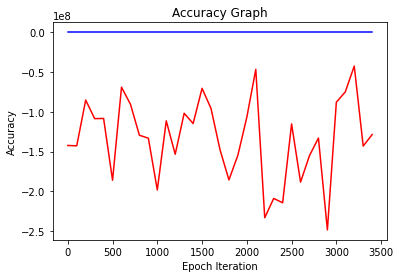

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(1)
#plt.plot(np.array(batches[0:34631][::100]), np.array(wasserstein_loss_array[::100]), color='green',
#                 label='Wasserstein Loss')

plt.plot(np.array(batches[0:34631][::100]), np.array(fake_accuracy_array[::100]), color='blue',
                 label='Real Accuracy')
plt.plot(np.array(batches[0:34631][::100]), np.array(real_accuracy_array[::100]), color='red',
                 label='Fake Accuracy')

plt.title("Accuracy Graph")
plt.xlabel("Epoch Iteration")
plt.ylabel("Accuracy")

plt.savefig('Accuracy_Plot.png')
plt.show()
plt.draw()

In [ ]:
print(generator.compiled_metrics == None)
print(discriminator.compiled_metrics == None)

False
False


In [ ]:
plt.figure(1)
plt.plot(np.array(batches[::12]), np.array(loss_gen_array[::12]), color='green',
                 label='Generator Loss')
plt.plot(np.array(batches[::12]), np.array(loss_disc_array[::12]), color='blue',
                 label='Discriminator Loss')
plt.title("Loss Graph")
plt.xlabel("Epoch Iteration")
plt.ylabel("Loss")
if epoch == 0:
  plt.legend()
  plt.pause(0.0000000001)
  plt.show()
  plt.savefig('trainingLossPlot.png')

In [ ]:
!dir

Copia_di_EAI_VPH_Project.ipynb	generated_images_256_new
dataset				models
generated_images		my_dataset
generated_images_256		training_checkpoints
generated_images_256_chkpt	training_checkpoints_new


In [ ]:
print(last_improvement)


118


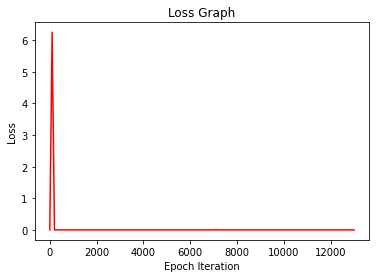

In [ ]:
plt.figure(1)
#plt.plot(np.array(batches[0:34631][::100]), np.array(wasserstein_loss_array[::100]), color='green',
#                 label='Wasserstein Loss')
#plt.plot(np.array(batches[0:34631][::100]), np.array(loss_gen_array[::100]), color='blue',
#                 label='Generator Loss')
plt.plot(np.array(batches[0:34631][::100]), np.array(loss_disc_array[::100]), color='red',
                 label='Discriminator Loss')

plt.title("Loss Graph")
plt.xlabel("Epoch Iteration")
plt.ylabel("Loss")
if epoch == 0:
  plt.legend()
  plt.pause(0.0000000001)
  #fig1 = plt.gcf()
  plt.savefig('trainingLossPlot_200.png')
  plt.show()
  plt.draw()

####Validation

In [ ]:
os.chdir('./models')

In [ ]:
ls

discriminator_epoch0.h5   discriminator_epoch4.h5  generator_epoch17.h5
discriminator_epoch10.h5  discriminator_epoch5.h5  generator_epoch18.h5
discriminator_epoch11.h5  discriminator_epoch6.h5  generator_epoch19.h5
discriminator_epoch12.h5  discriminator_epoch7.h5  generator_epoch1.h5
discriminator_epoch13.h5  discriminator_epoch8.h5  generator_epoch2.h5
discriminator_epoch14.h5  discriminator_epoch9.h5  generator_epoch3.h5
discriminator_epoch15.h5  generator_epoch0.h5      generator_epoch4.h5
discriminator_epoch16.h5  generator_epoch10.h5     generator_epoch5.h5
discriminator_epoch17.h5  generator_epoch11.h5     generator_epoch6.h5
discriminator_epoch18.h5  generator_epoch12.h5     generator_epoch7.h5
discriminator_epoch19.h5  generator_epoch13.h5     generator_epoch8.h5
discriminator_epoch1.h5   generator_epoch14.h5     generator_epoch9.h5
discriminator_epoch2.h5   generator_epoch15.h5
discriminator_epoch3.h5   generator_epoch16.h5


In [ ]:
generator = load_model('generator_epoch30.h5')

In [ ]:
discriminator= load_model('discriminator_epoch30.h5')

In [ ]:
tf.keras.utils.plot_model(discriminator)

In [ ]:
generator.compile()

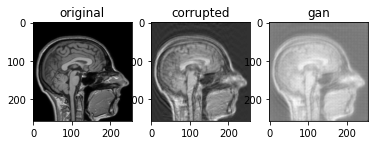

In [ ]:
corr= (validation_scan_x)/255
fake= generator.predict(corr)


img_corr = np.array(corr[0])
img_corr = img_corr.astype('float64')
img_corr = tf.keras.utils.array_to_img(img_corr)

img_og= np.array(og_scan_x[0])
img_og = img_og.astype('float64')
img_og = tf.keras.utils.array_to_img(img_og)

img = np.array(fake[0])
img = img.astype('float64')
img = tf.keras.utils.array_to_img(img)
#img.save("./validationimg_"+slice_no+"_x.png")

f = plt.figure()
f.add_subplot(1 ,3, 1)
plt.title('original')
plt.imshow(img_og, cmap='gray')
f.add_subplot(1, 3, 2)
plt.title('corrupted')
plt.imshow(img_corr, cmap='gray')
f.add_subplot(1, 3, 3)
plt.title('gan')
plt.imshow(img, cmap= 'gray')
plt.show(block=True)

f.savefig("./validationplot"+slice_no+"x.png")

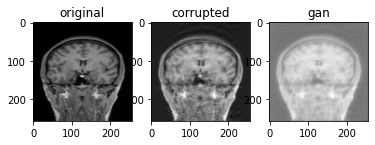

In [ ]:
corr= validation_scan_y/255
fake= generator(corr, training= False)


img_corr = np.array(corr[0])
img_corr = img_corr.astype('float64')
img_corr = tf.keras.utils.array_to_img(img_corr)

img_og= np.array(og_scan_y[0])
img_og = img_og.astype('float64')
img_og = tf.keras.utils.array_to_img(img_og)


img = np.array(fake[0])
img = img.astype('float64')
img = tf.keras.utils.array_to_img(img)
#img.save("./validationimg_"+slice_no+"_y.png")


f = plt.figure()
f.add_subplot(1 ,3, 1)
plt.title('original')
plt.imshow(img_og, cmap='gray')
f.add_subplot(1, 3, 2)
plt.title('corrupted')
plt.imshow(img_corr, cmap='gray')
f.add_subplot(1, 3, 3)
plt.title('gan')
plt.imshow(img, cmap= 'gray')
plt.show(block=True)

f.savefig("./validationplot"+slice_no+"y.png")

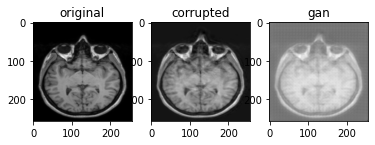

In [ ]:
corr= validation_scan_z/255
fake= generator(corr, training= False)


img_corr = np.array(corr[0])
img_corr = img_corr.astype('float64')
img_corr = tf.keras.utils.array_to_img(img_corr)

img_og= np.array(og_scan_z[0])
img_og = img_og.astype('float64')
img_og = tf.keras.utils.array_to_img(img_og)


img = np.array(fake[0])
img = img.astype('float64')
img = tf.keras.utils.array_to_img(img)
#img.save("./validationimg_"+slice_no+"_z.png")


f = plt.figure()
f.add_subplot(1 ,3, 1)
plt.title('original')
plt.imshow(img_og, cmap='gray')
f.add_subplot(1, 3, 2)
plt.title('corrupted')
plt.imshow(img_corr, cmap='gray')
f.add_subplot(1, 3, 3)
plt.title('gan')
plt.imshow(img, cmap= 'gray')
plt.show(block=True)

f.savefig("./validationplot"+slice_no+"z.png")